In [2]:
import os
import sys
from statistics import mean
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run utils.ipynb

In [4]:
#Loading Data
df = pd.read_csv('room_occupancy.csv',index_col='rentaldate').drop('Unnamed: 0', axis=1)
df.head()
df.tail()

,occupancy
rentaldate,
2022-05-27,28.4375
2022-05-28,28.7500
2022-05-29,23.4375
2022-05-30,23.4375
2022-05-31,22.5000


In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
#check for data stationary 
df.apply(adfuller_test)

ADF Test Statistic : -3.799270030747603
p-value : 0.0029147923694822545
#Lags Used : 22
Number of Observations Used : 1909
Null hypothesis is rejected. Series is stationary.


occupancy    None
dtype: object

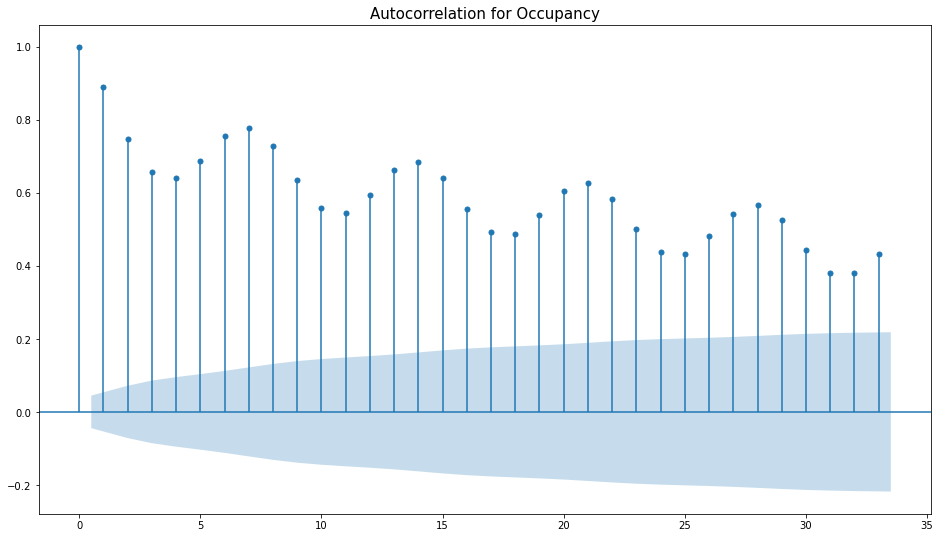

In [7]:
#Autocorrelation plot
fig, ax = plt.subplots(figsize=(16,9))
plot_acf(df.resample('D')['occupancy'].sum(), ax=ax)
plt.title('Autocorrelation for Occupancy', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

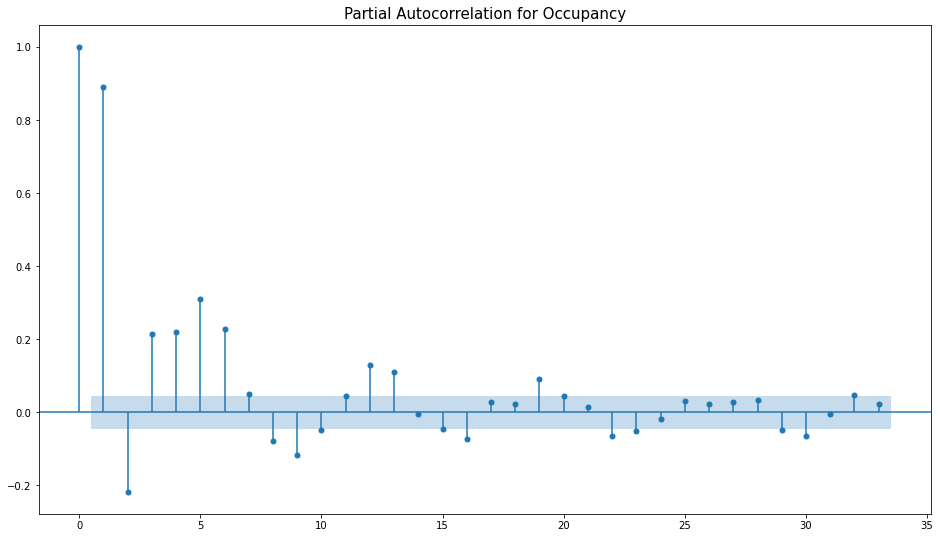

In [8]:
#Partial Autocorrelation 
fig, ax = plt.subplots(figsize=(16,9))
plot_pacf(df.resample('D')['occupancy'].sum(), ax=ax)
plt.title('Partial Autocorrelation for Occupancy', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [9]:
#Spliting in train/test
df_train = df.loc[(df.index.year >= 2017) & (df.index.year != 2022),:]
df_test = df.loc[df.index.year == 2022,:]

In [12]:
sarima = SARIMAX(endog=df_train,order=(2,1,0),seasonal_order=(2,0,2,12)).fit()
sarima_pred = sarima.predict()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               occupancy   No. Observations:                 1781
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -4718.754
Date:                                 Sat, 06 Aug 2022   AIC                           9451.509
Time:                                         15:34:56   BIC                           9489.899
Sample:                                     02-15-2017   HQIC                          9465.688
                                          - 12-31-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0197      0.020      1.001      0.317      -0.019       0.058
ar.L2         -0.2780      0.021    -12.944      0.000      -0.320      -0.236
ar.S.L12      -0.4378      0.005    -82.220      0.000      -0.448      -0.427
ar.S.L24      -0.9949      0.003   -299.004      0.000      -1.001      -0.988
ma.S.L12       0.4156      0.014     28.961      0.000       0.387       0.444
ma.S.L24       0.9391      0.015     63.855      0.000       0.910       0.968
sigma2        11.5493      0.335     34.426      0.000      10.892      12.207
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):                62.92
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
sarima.aic

9451.508675567991

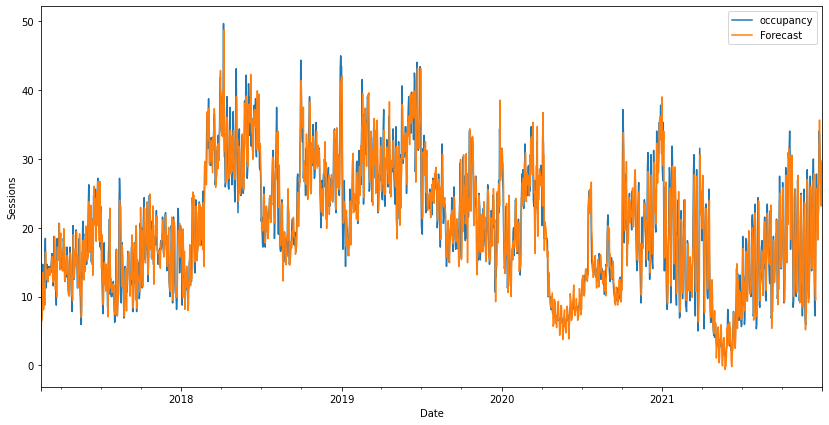

In [14]:
ax = df_train.plot(label='observed')
sarima_pred.to_frame(name='Forecast').plot(ax=ax, label='Dynamic Forecast', figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
#plt.title(f'Dynamic Forecast for {county}')
plt.legend()
plt.show()